In [17]:
import os
import pandas as pd
from sqlalchemy import create_engine, text
from getpass import getpass
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import scipy.stats as stats
from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [18]:
# Connection parameters to PostgreSQL
DB_USER = "postgres"         
DB_PASSWORD = getpass()
DB_HOST = "localhost"         
DB_PORT = "5432"             
DB_NAME = "ecommerce"         

# Create connection
engine = create_engine(f'postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')

 ········


In [54]:
df = pd.read_sql('''
SELECT *
FROM order_sample_ready_for_feature_analysis
''', engine)

df.head()

,order_id,product_name_lenght_min,product_name_lenght_max,product_name_lenght_mean,product_name_lenght_median,product_name_lenght_std,product_description_lenght_min,product_description_lenght_max,product_description_lenght_mean,product_description_lenght_median,...,max_review_score,std_review_score,delivery_time,estimated_delivery_days,type_count_boleto,type_count_credit_card,type_count_debit_card,type_count_not_defined,type_count_voucher,sel2cust_dist
0,00010242-fe8c-5a6d-1ba2-dd792cb16214,58.0,58.0,58.0,58.0,0.0,598.0,598.0,598.0,598.0,...,5.0,1.338863,7.0,15.0,False,True,False,False,False,0.000000
1,00018f77-f2f0-320c-5571-90d7a144bdd3,56.0,56.0,56.0,56.0,0.0,239.0,239.0,239.0,239.0,...,5.0,1.443439,16.0,18.0,False,True,False,False,False,5.510120
2,000229ec-3982-24ef-6ca0-657da4fc703e,59.0,59.0,59.0,59.0,0.0,695.0,695.0,695.0,695.0,...,5.0,1.263700,8.0,21.0,False,True,False,False,False,2.865357
3,00024acb-cdf0-a6da-a1e9-31b038114c75,42.0,42.0,42.0,42.0,0.0,480.0,480.0,480.0,480.0,...,5.0,1.677051,6.0,11.0,False,True,False,False,False,2.652272
4,00042b26-cf59-d7ce-69df-abb4e55b4fd9,59.0,59.0,59.0,59.0,0.0,409.0,409.0,409.0,409.0,...,5.0,1.310345,25.0,40.0,False,True,False,False,False,6.316069


In [58]:
# Kep only features in dataset (numeric)

df = df.select_dtypes(include=[np.number])

In [59]:
# That's because some features were calculated in miliseconds in PostgreSQL

for c in df.columns:
    if 'shipping' in c:
        df[c] = df[c].astype(int) / 1e6 / 86400

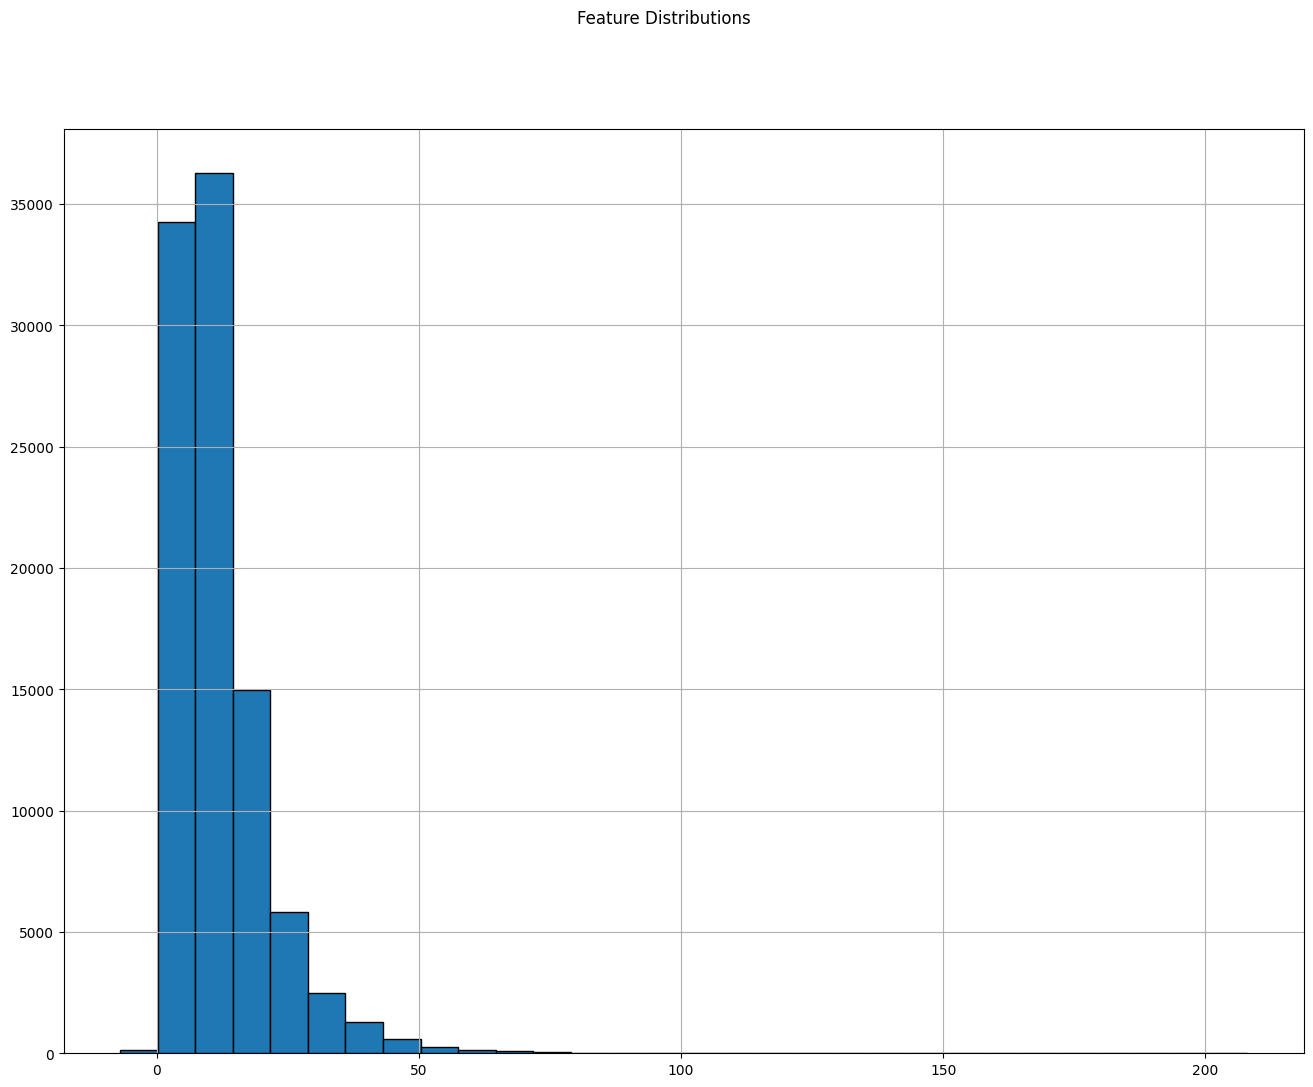

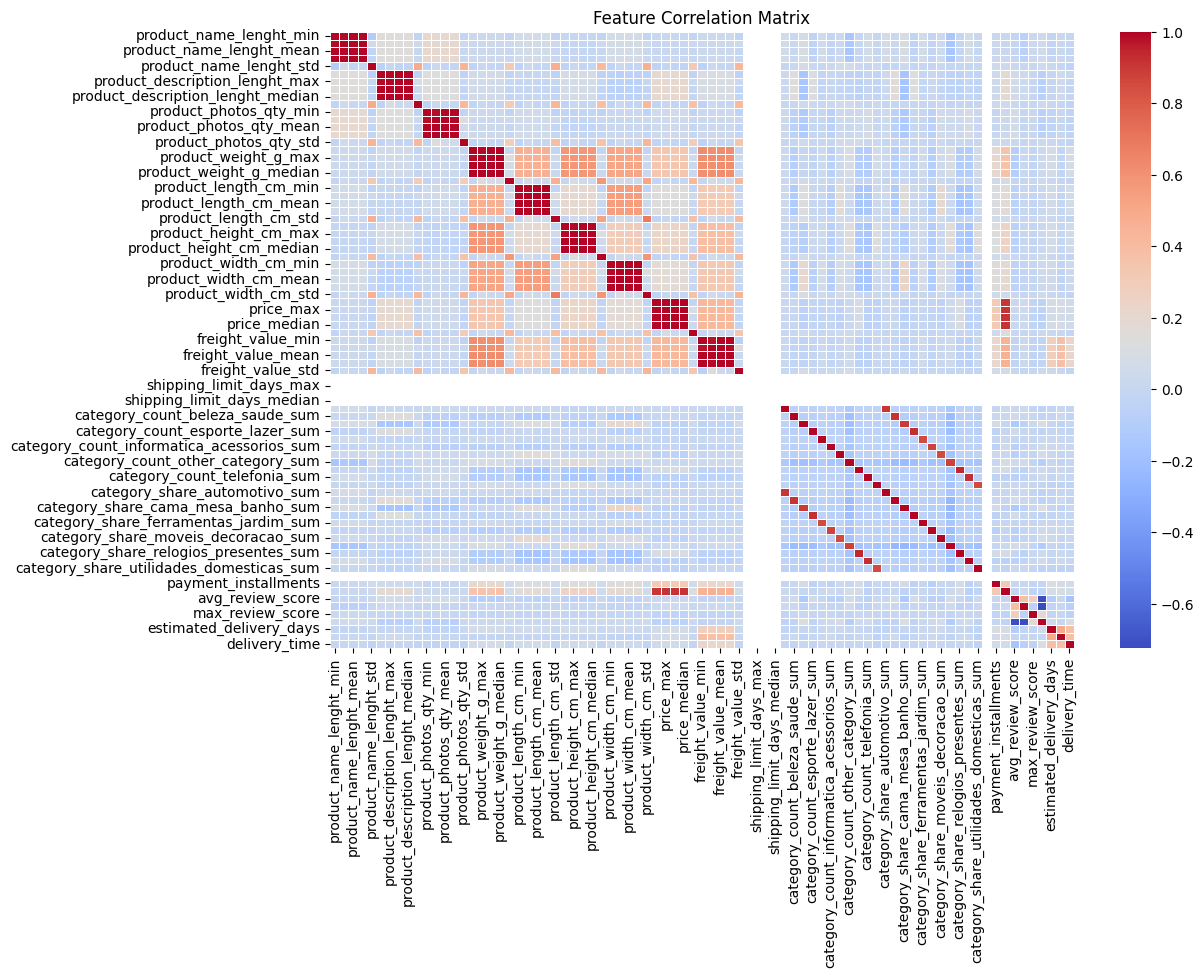

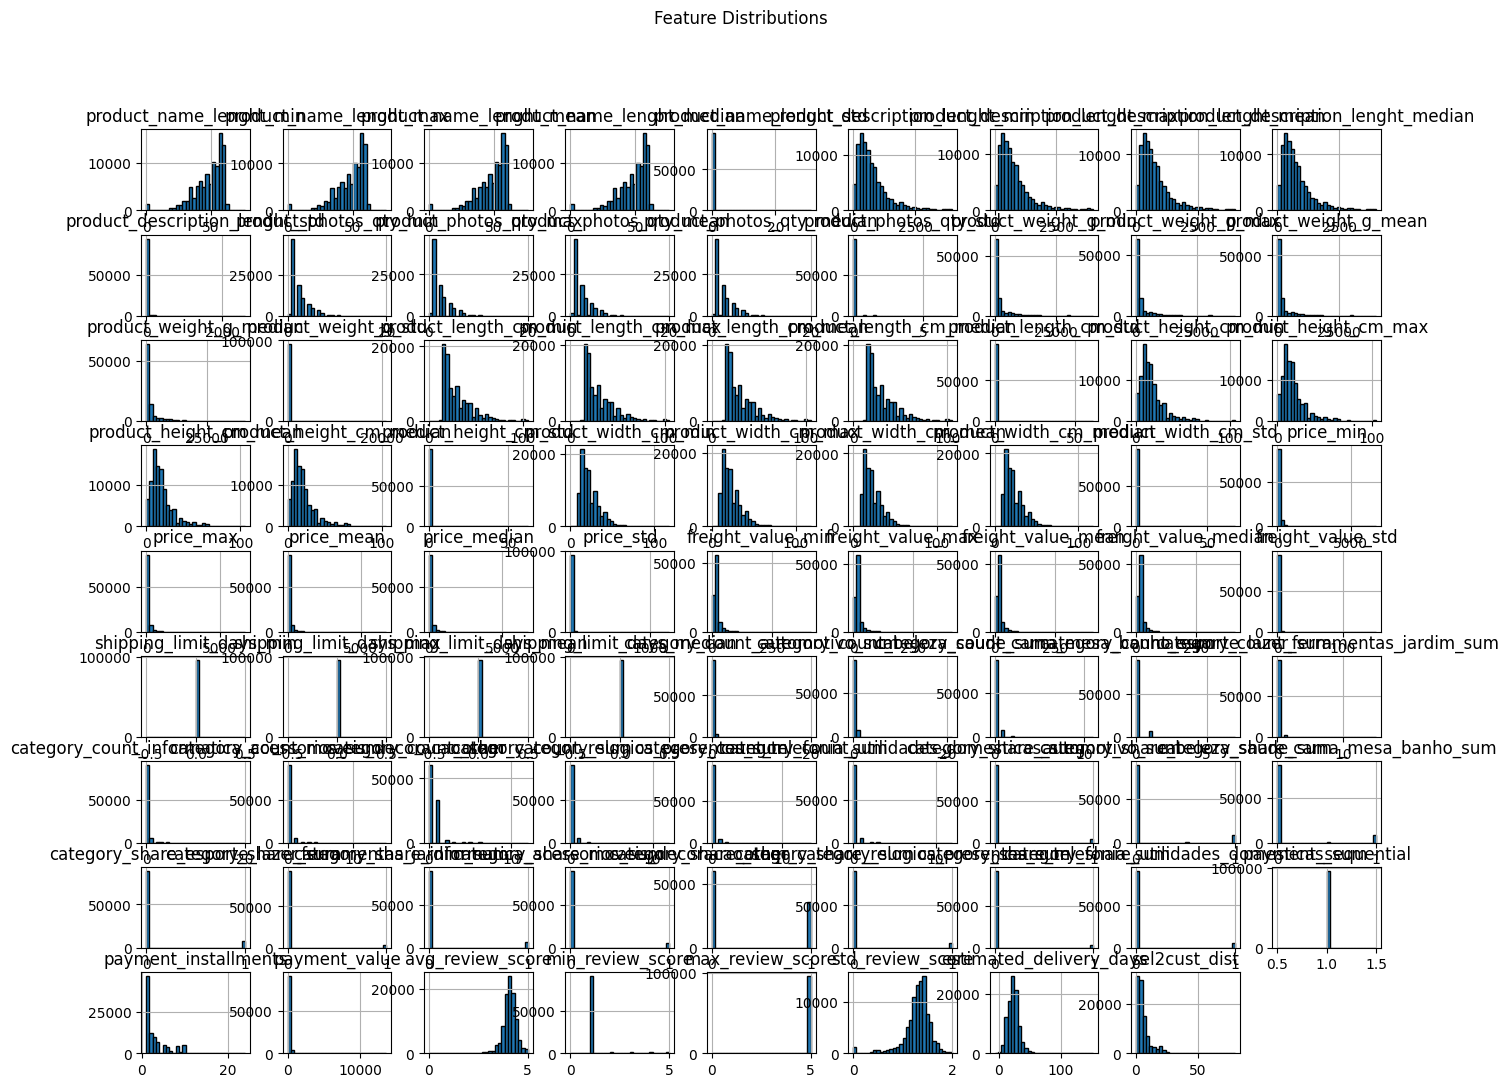

In [61]:
def plot_correlation_matrix(df):
    plt.figure(figsize=(12, 8))
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
    plt.title("Feature Correlation Matrix")
    plt.show()

def plot_feature_distributions(df, num_cols):
    df[num_cols].hist(figsize=(16, 12), bins=30, edgecolor='k')
    plt.suptitle("Feature Distributions")
    plt.show()

target = "delivery_time"

plot_feature_distributions(df, target)

# Select numerical features
num_cols = df.select_dtypes(include=['number']).columns.tolist()
num_cols.remove(target)  # Exclude target

# Corellation matrix
plot_correlation_matrix(df[num_cols + [target]])

# Distributions visualization
plot_feature_distributions(df, num_cols)


/var/folders/q8/ftp_43616hxb8y78vh3691gw0000gn/T/ipykernel_3801/3013736013.py:11: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(df[col], df[TARGET], nan_policy='omit')


Корреляция с таргетом:
                         Spearman Correlation
estimated_delivery_days              0.522489
sel2cust_dist                        0.510517
freight_value_mean                   0.432939
freight_value_median                 0.432193
freight_value_min                    0.430811
freight_value_max                    0.426265
std_review_score                     0.144970
payment_value                        0.140997
price_min                            0.116740
price_median                         0.114503
Random Forest Feature Importance:
                    Feature  Importance
78  estimated_delivery_days    0.172016
79            sel2cust_dist    0.167622
74         avg_review_score    0.059714
73            payment_value    0.041784
77         std_review_score    0.034364
40        freight_value_min    0.033994
72     payment_installments    0.027652
41        freight_value_max    0.019239
42       freight_value_mean    0.017965
43     freight_value_median    0.0177

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Permutation Importance:
                    Feature  Permutation Importance
79            sel2cust_dist                0.218312
78  estimated_delivery_days                0.104999
74         avg_review_score                0.058232
40        freight_value_min                0.041422
35                price_min                0.039725
73            payment_value                0.016679
42       freight_value_mean                0.016654
77         std_review_score                0.014794
41        freight_value_max                0.011497
43     freight_value_median                0.008362


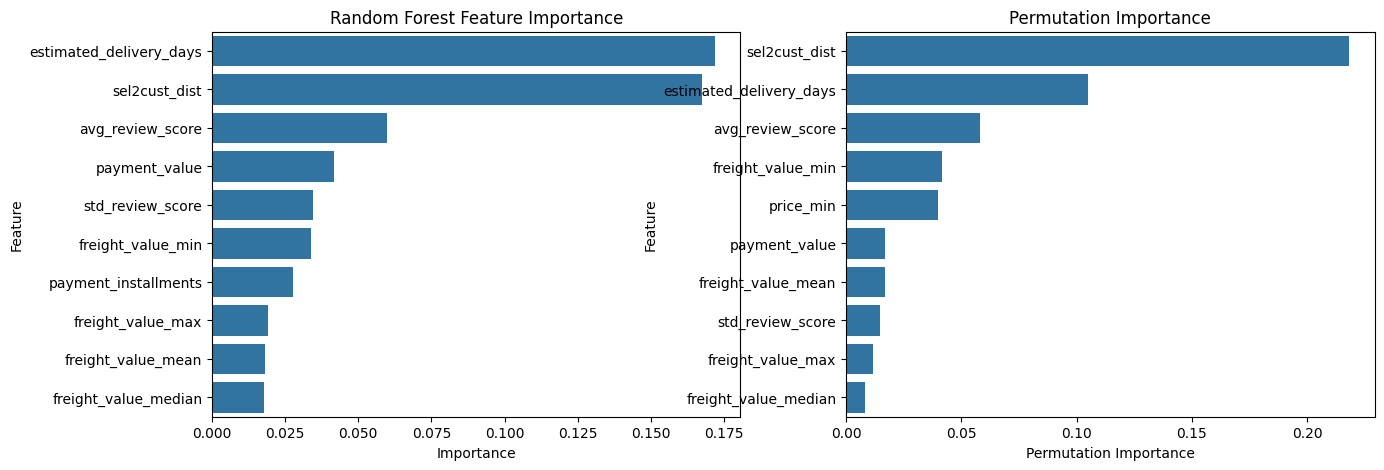

In [62]:
# Numerical and categorical features
num_features = df.select_dtypes(include=[np.number]).columns.tolist()
cat_features = df.select_dtypes(exclude=[np.number]).columns.tolist()

TARGET = "delivery_time"
num_features.remove(TARGET)

# Corellation with target
corr_results = {}
for col in num_features:
    corr, _ = spearmanr(df[col], df[TARGET], nan_policy='omit')
    corr_results[col] = corr

corr_df = pd.DataFrame.from_dict(corr_results, orient='index', columns=['Spearman Correlation'])
corr_df.sort_values(by='Spearman Correlation', ascending=False, inplace=True)
print("Корреляция с таргетом:")
print(corr_df.head(10))

# Random Forest Feature Importance
X = df[num_features]
y = df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

rf_importances = pd.DataFrame({'Feature': num_features, 'Importance': rf.feature_importances_})
rf_importances.sort_values(by='Importance', ascending=False, inplace=True)
print("Random Forest Feature Importance:")
print(rf_importances.head(10))

# Permutation Importance
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_df = pd.DataFrame({'Feature': num_features, 'Permutation Importance': perm_importance.importances_mean})
perm_df.sort_values(by='Permutation Importance', ascending=False, inplace=True)
print("Permutation Importance:")
print(perm_df.head(10))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(data=rf_importances.head(10), x='Importance', y='Feature', ax=axes[0])
axes[0].set_title("Random Forest Feature Importance")
sns.barplot(data=perm_df.head(10), x='Permutation Importance', y='Feature', ax=axes[1])
axes[1].set_title("Permutation Importance")
plt.show()

# Save results
corr_df.to_csv("correlation_results.csv")
rf_importances.to_csv("rf_importances.csv")
perm_df.to_csv("permutation_importance.csv")


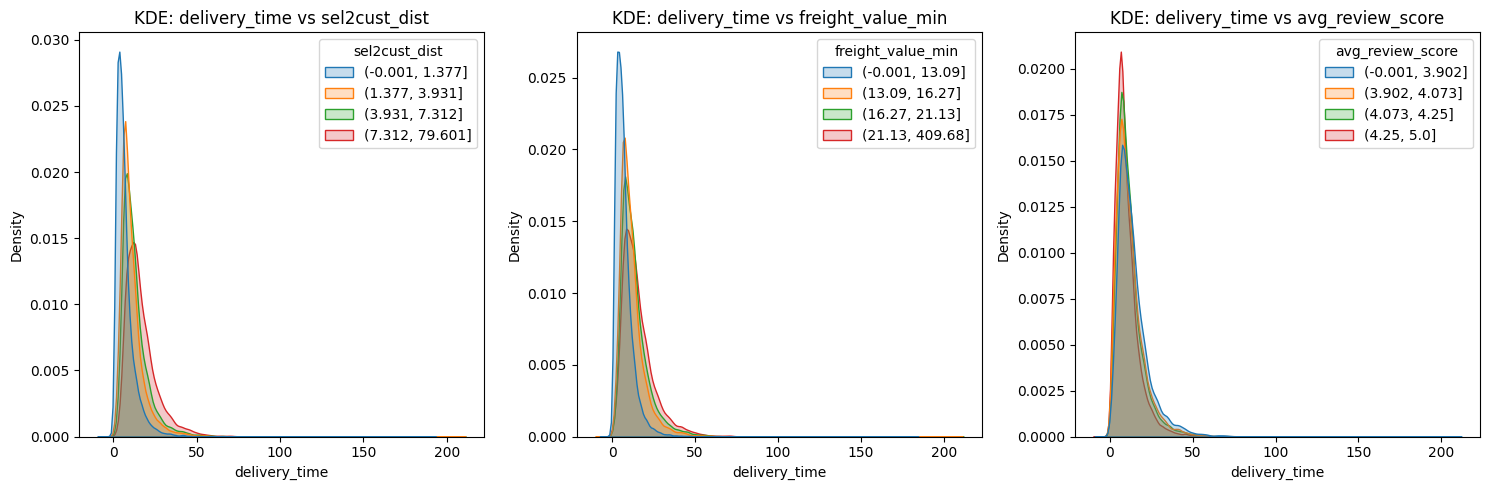

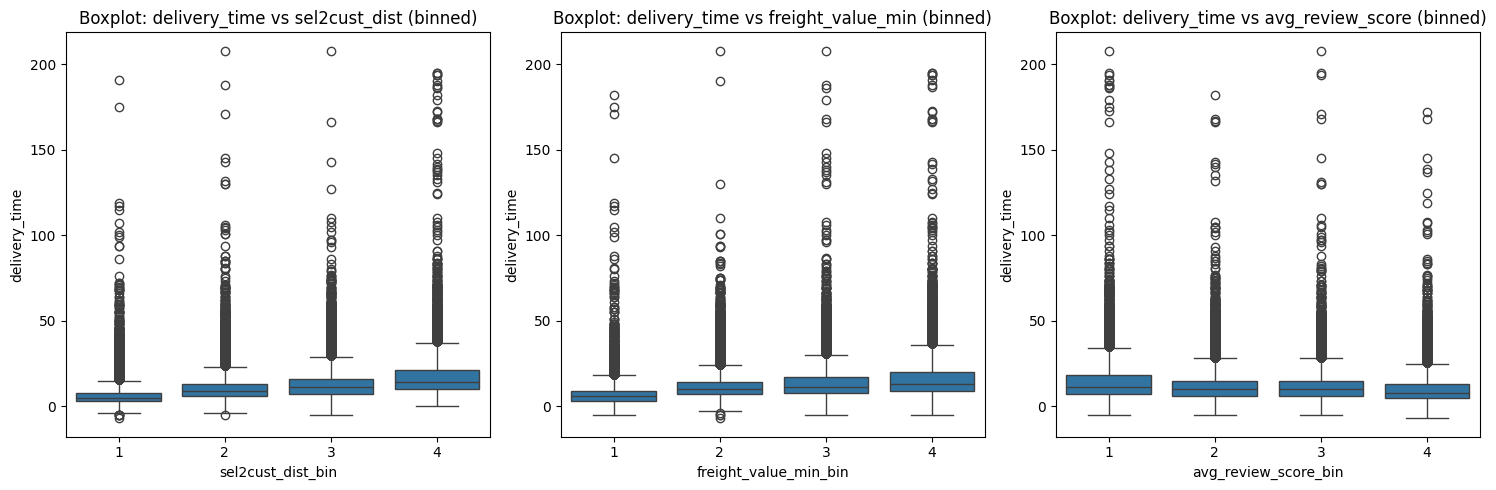

/var/folders/q8/ftp_43616hxb8y78vh3691gw0000gn/T/ipykernel_3801/2813099094.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  woe_table = temp_df.groupby("bin")["delivery_time"].mean().reset_index()
/var/folders/q8/ftp_43616hxb8y78vh3691gw0000gn/T/ipykernel_3801/2813099094.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  woe_table = temp_df.groupby("bin")["delivery_time"].mean().reset_index()
/var/folders/q8/ftp_43616hxb8y78vh3691gw0000gn/T/ipykernel_3801/2813099094.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=

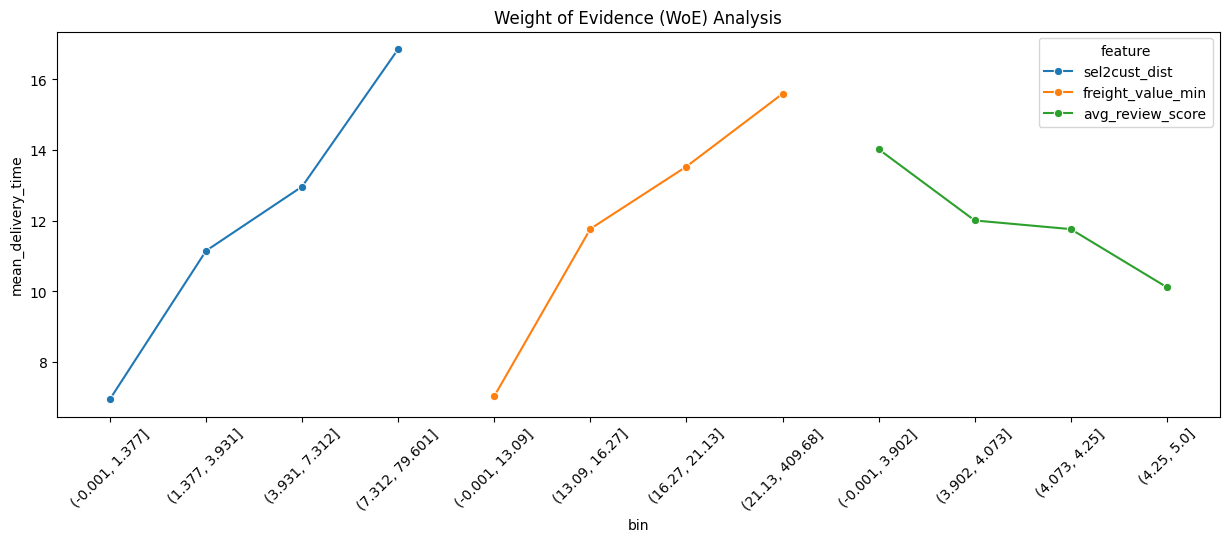


📊 Top/Flop groups (average values by key features):
                    Top 10% (High delivery_time)  \
sel2cust_dist                          9.519950   
freight_value_min                     26.779349   
avg_review_score                       3.929369   

                   Bottom 10% (Low delivery_time)  
sel2cust_dist                            1.087372  
freight_value_min                       12.177763  
avg_review_score                         4.152849  


In [63]:
# Strongest features analysis
key_features = ["sel2cust_dist", "freight_value_min", "avg_review_score"]

# KDE
plt.figure(figsize=(15, 5))
for i, feature in enumerate(key_features):
    plt.subplot(1, len(key_features), i+1)
    sns.kdeplot(df, x="delivery_time", hue=pd.qcut(df[feature], q=4), fill=True)
    plt.title(f"KDE: delivery_time vs {feature}")
plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(15, 5))
for i, feature in enumerate(key_features):
    df[f"{feature}_bin"] = pd.qcut(df[feature], q=4, labels=[1, 2, 3, 4])
    plt.subplot(1, len(key_features), i+1)
    sns.boxplot(data=df, x=f"{feature}_bin", y="delivery_time")
    plt.title(f"Boxplot: delivery_time vs {feature} (binned)")
plt.tight_layout()
plt.show()

# Weight of Evidence (WoE)
woe_data = []
for feature in key_features:
    temp_df = df.copy()  # Создаём временную копию
    temp_df["bin"] = pd.qcut(temp_df[feature], q=4, duplicates="drop")  # Биннинг
    woe_table = temp_df.groupby("bin")["delivery_time"].mean().reset_index()
    woe_table.columns = ["bin", "mean_delivery_time"]
    woe_table["feature"] = feature
    woe_data.append(woe_table)
    
woe_df = pd.concat(woe_data)

woe_df["bin"] = woe_df["bin"].astype(str) 

plt.figure(figsize=(15, 5))
sns.lineplot(data=woe_df, x="bin", y="mean_delivery_time", hue="feature", marker="o")
plt.xticks(rotation=45)
plt.title("Weight of Evidence (WoE) Analysis")
plt.show()

# top/flop groups analyzis
top_10 = df.nlargest(int(0.1 * len(df)), "delivery_time")
bottom_10 = df.nsmallest(int(0.1 * len(df)), "delivery_time")

summary_top = top_10[key_features].mean()
summary_bottom = bottom_10[key_features].mean()

comparison_df = pd.DataFrame({"Top 10% (High delivery_time)": summary_top, "Bottom 10% (Low delivery_time)": summary_bottom})
print("\n📊 Top/Flop groups (average values by key features):\n", comparison_df)


In [64]:
# Feature selection

TARGET = "delivery_time"  
N_TOP_FEATURES = 20  # Select top-20 features

def remove_correlated_features(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    df = df.drop(columns=to_drop)
    print(f"Удалено {len(to_drop)} скоррелированных фичей.")
    return df

df = remove_correlated_features(df, threshold=0.9)

# Select by Random Forest / Permutation Importance

X = df.drop(columns=[TARGET])
y = df[TARGET]

# Train-test split for permutation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
print('Random Forest finished')

# Feature Importance по Random Forest
rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Permutation Importance
from sklearn.linear_model import Ridge

simple_model = Ridge()
simple_model.fit(X_train, y_train)
perm_importance = permutation_importance(simple_model, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)
perm_importances = pd.Series(perm_importance.importances_mean, index=X.columns).sort_values(ascending=False)
print('Permutation Importance finished')

# Select top features
top_features = set(rf_importances.head(N_TOP_FEATURES).index) | set(perm_importances.head(N_TOP_FEATURES).index)
df = df[list(top_features) + [TARGET]]

print(f"Оставлено {len(top_features)} фич по важности из {X.shape[1]}.")


# Remove features with high VIF
def remove_high_vif_features(df, threshold=10):
    features = df.drop(columns=[TARGET]).columns
    vif_data = pd.DataFrame()
    vif_data["Feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(df.drop(columns=[TARGET]).values, i) for i in range(len(features))]

    while vif_data["VIF"].max() > threshold:
        to_remove = vif_data.sort_values("VIF", ascending=False).iloc[0]["Feature"]
        df = df.drop(columns=[to_remove])
        vif_data = pd.DataFrame()
        vif_data["Feature"] = df.drop(columns=[TARGET]).columns
        vif_data["VIF"] = [variance_inflation_factor(df.drop(columns=[TARGET]).values, i) for i in range(len(vif_data))]
        print(f"Удалена фича {to_remove} с VIF = {vif_data['VIF'].max()}")

    return df

df = remove_high_vif_features(df, threshold=10)

print(f"Final number of features: {df.shape[1] - 1}") 

Удалено 33 скоррелированных фичей.
Random Forest finished
Permutation Importance finished
Оставлено 29 фич по важности из 50.
Удалена фича avg_review_score с VIF = 20.589811813454343
Удалена фича sel2cust_dist_bin с VIF = 18.60760747072321
Удалена фича product_name_lenght_min с VIF = 13.860370328514518
Удалена фича freight_value_min_bin с VIF = 12.18753585036303
Удалена фича std_review_score с VIF = 9.1073440058898
Final number of features: 24


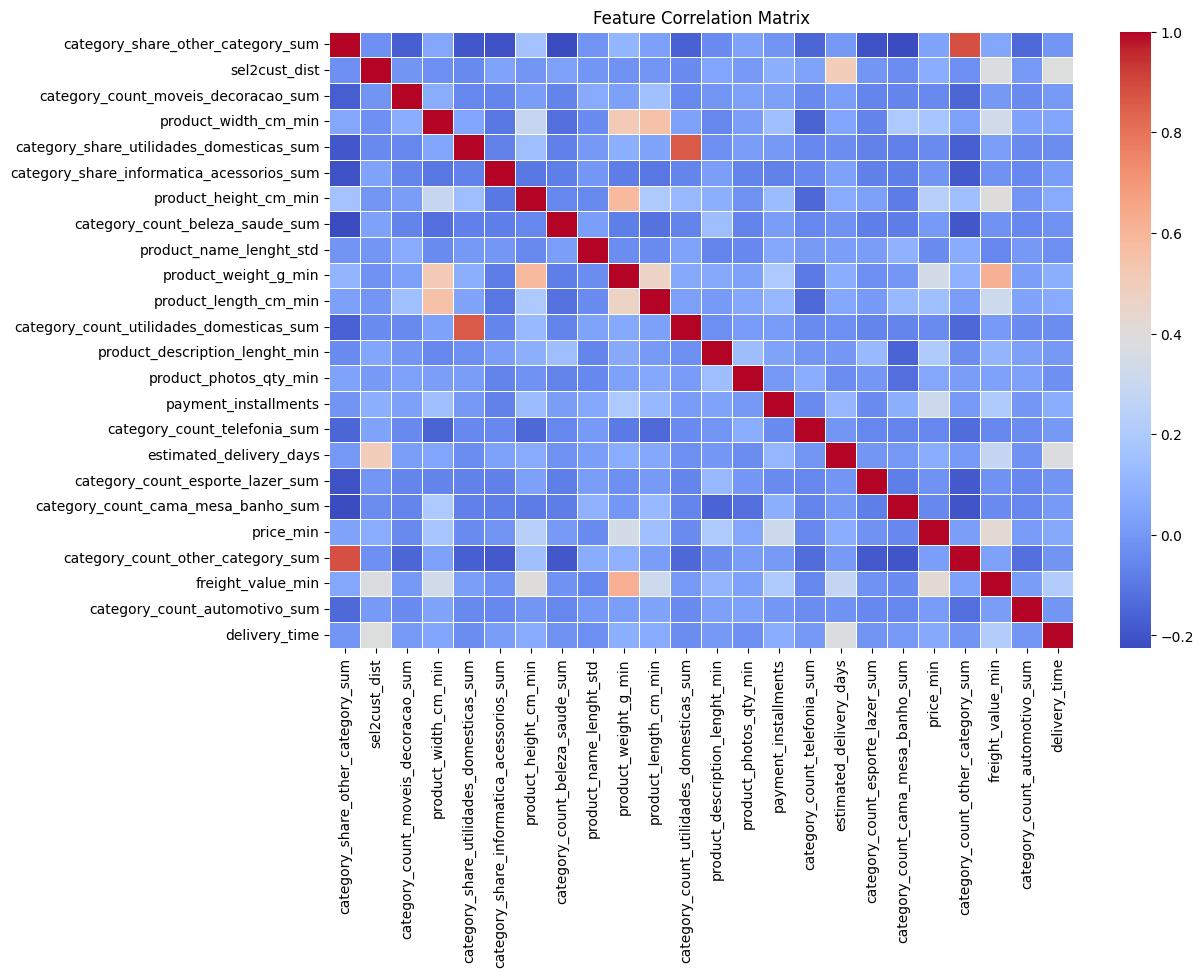

In [65]:
plot_correlation_matrix(df.select_dtypes(include=['number']))

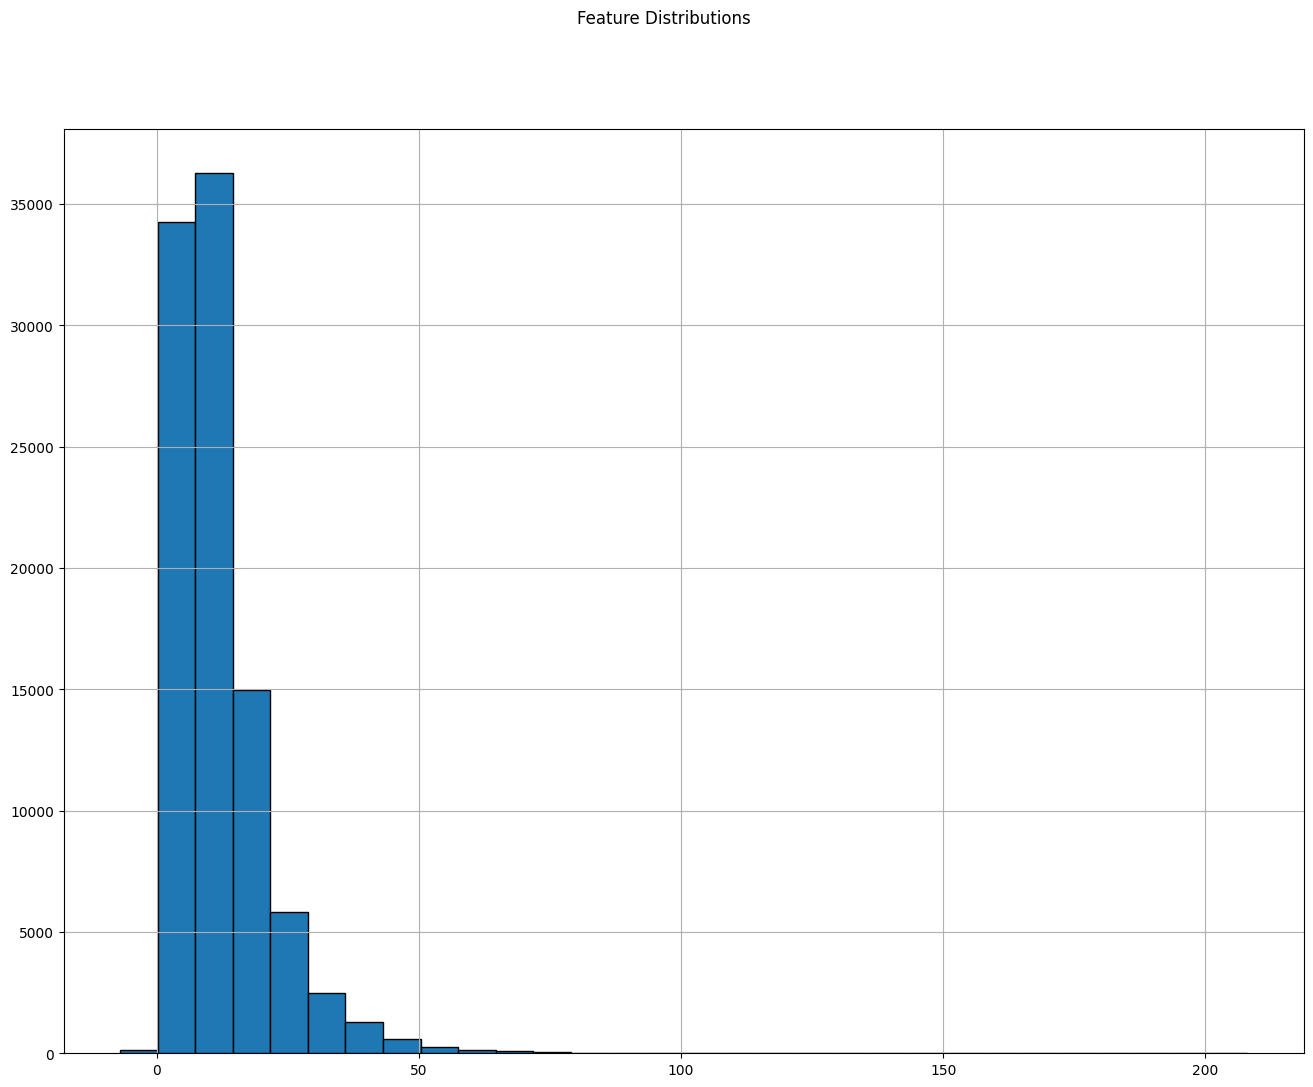

In [66]:
plot_feature_distributions(df,target)

# Consider data ready for baseline ML

In [67]:
df.to_sql('order_sample_ready_to_ml_features_fixed', engine, if_exists="replace", index=False)

383

In [68]:
pd.read_sql('''
SELECT COUNT(*)
FROM order_sample_ready_to_ml_features_fixed
LIMIT 5;
''', engine)

,count
0,96383


In [69]:
pd.read_sql('''
SELECT *
FROM order_sample_ready_to_ml_features_fixed
LIMIT 5;
''', engine)

,category_share_other_category_sum,sel2cust_dist,category_count_moveis_decoracao_sum,avg_review_score_bin,product_width_cm_min,category_share_utilidades_domesticas_sum,category_share_informatica_acessorios_sum,product_height_cm_min,category_count_beleza_saude_sum,product_name_lenght_std,...,payment_installments,category_count_telefonia_sum,estimated_delivery_days,category_count_esporte_lazer_sum,category_count_cama_mesa_banho_sum,price_min,category_count_other_category_sum,freight_value_min,category_count_automotivo_sum,delivery_time
0,1.0,0.000000,0,2,14.0,0.0,0.0,9.0,0,0.0,...,2,0,15.0,0,0,58.90,1,13.29,0,7.0
1,1.0,5.510120,0,1,40.0,0.0,0.0,30.0,0,0.0,...,3,0,18.0,0,0,239.90,1,19.93,0,16.0
2,0.0,2.865357,1,1,33.0,0.0,0.0,13.0,0,0.0,...,5,0,21.0,0,0,199.00,0,17.87,0,8.0
3,1.0,2.652272,0,1,15.0,0.0,0.0,10.0,0,0.0,...,2,0,11.0,0,0,12.99,1,12.79,0,6.0
4,0.0,6.316069,0,1,30.0,0.0,0.0,40.0,0,0.0,...,3,0,40.0,0,0,199.90,0,18.14,0,25.0
